# Slurm resource usage 

In [1]:
cd ~/old_FP_prod/logs

/usr/users/ga004/buntingd/old_FP_prod/logs


In [2]:
import numpy as np
import sys
import os
import re
import io
import math
import subprocess
import pandas as pd

import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
sns.set_style("whitegrid")

pow_to_G = dict(zip(['', 'B', 'K', 'M', 'G'], [1024**-3, 1024**-3, 1024**-2, 1024**-1, 1024**0]))
%matplotlib inline

In [3]:
def to_gigabytes(size):
    if type(size) is not str:
        return size
    base, unit = re.match("([\.\d]+)([BKMG]?)", size).groups()
    return math.ceil(float(base) * pow_to_G[unit] * 10**3) / 10**3


def parse_slurm_time(t_str):
    # format is [DD-[hh:]]mm:ss
    # return decimal hours
    s1 = t_str.split(':')
    # always have mins/secs
    secs = int(s1[-1])
    mins = int(s1[-2])

    if len(s1) > 2:
        s2 = s1[0].split('-')
        if len(s2) == 1:
            hours = int(s2[0])
            days = 0
        else:
            hours = int(s2[1])
            days = int(s2[0])
    return 24 * days + hours + mins / 60. + secs / (60.**2)


class Task():

    def __init__(self, task_id, jobid):
        super(Task).__init__()

        self.task_id = task_id
        self.type, self.lib, =  re.match('^(\S+)_(LIB\S+?)_', self.task_id).groups()
        # Differentiate Tasks run for a lib and those run for all samples
        if '_' in self.type:
            self.type = self.type.split('_')[0]
            self.lib = ''

        self.jobid = jobid


In [4]:
cat *.salloc.log > combined.txt

In [5]:
task_file = "combined.txt"
base_dir = task_file.rsplit(".", 1)[0]

tasks = {}
with open(task_file, 'r') as f:
    for line in f:
        task_id, jobid = line.rstrip().split('\t')
        tasks[task_id] = jobid

jobid_query = ','.join([t + '.0' for t in tasks.values()])
p = subprocess.run("sacct -P --format=jobid,elapsed,MaxDiskWrite,MaxDiskRead,AveRSS,MaxRSS,AveVMSize,MaxVMSize,state,ExitCode -j " +
                   jobid_query, shell=True, universal_newlines=True, stdout=subprocess.PIPE)

task_table = pd.read_table(io.StringIO(p.stdout), sep='|')

In [6]:
task_table['JobID'] = task_table['JobID'].astype(str).str.split('.').str.get(0)
task_table['Type'] = [t.split('_')[0] for t in tasks.keys()]

task_table['Elapsed'] = task_table['Elapsed'].map(parse_slurm_time)
for mem in ['MaxDiskWrite', 'MaxDiskRead', 'AveRSS', 'MaxRSS', 'AveVMSize', 'MaxVMSize']:
    task_table[mem] = task_table[mem].map(to_gigabytes)

completed = task_table.ix[task_table['State'] == 'COMPLETED']
completed.head()

,JobID,Elapsed,MaxDiskWrite,MaxDiskRead,AveRSS,MaxRSS,AveVMSize,MaxVMSize,State,ExitCode,Type
0,8247751,0.028889,4.563,4.563,0.004,0.004,0.327,0.327,COMPLETED,0:0,MarkDuplicates
1,8247752,0.026944,5.125,5.126,0.004,0.004,0.327,0.327,COMPLETED,0:0,Star
2,8247753,0.178056,3.752,3.752,0.003,0.005,0.327,0.450,COMPLETED,0:0,HaplotypeCaller
3,8247754,0.028056,4.699,4.700,0.004,0.005,0.327,0.450,COMPLETED,0:0,FetchFastqGZ
4,8247760,0.429167,5.313,5.313,0.004,0.005,0.327,0.450,COMPLETED,0:0,FetchFastqGZ


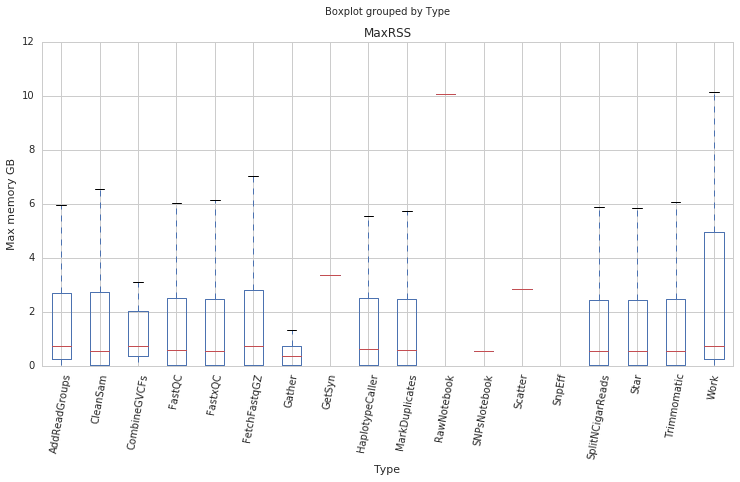

In [7]:
plt.figure(figsize=(12,6))
completed.boxplot(column='MaxRSS', by='Type', ax=plt.gca())
plt.xticks(rotation=80)
plt.ylabel("Max memory GB")
#plt.ylim((0,6))

(0, 1.2)

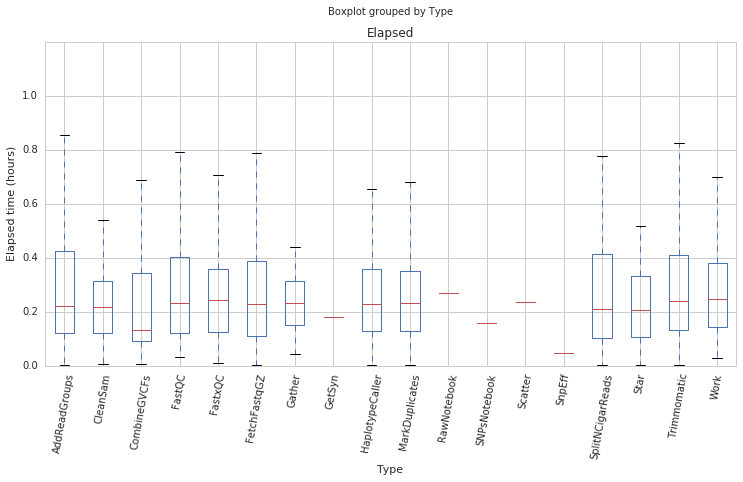

In [8]:
plt.figure(figsize=(12,6))
completed.boxplot(column='Elapsed', by='Type', ax=plt.gca())
plt.xticks(rotation=80)
plt.ylabel("Elapsed time (hours)")
plt.ylim((0,1.2))